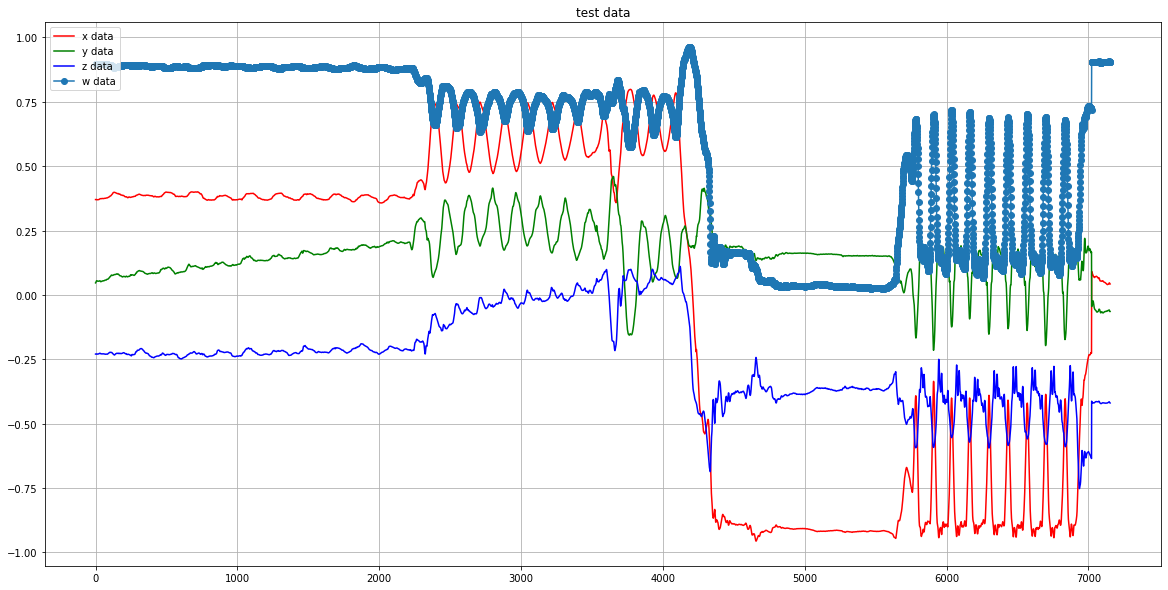

[2394 2544 2710 2886 3046 3221 3399 3584 3771 3935 4090 4657 5822 5945
 6070 6199 6356 6490 6624 6757 6871]
7154


<Figure size 1440x720 with 0 Axes>

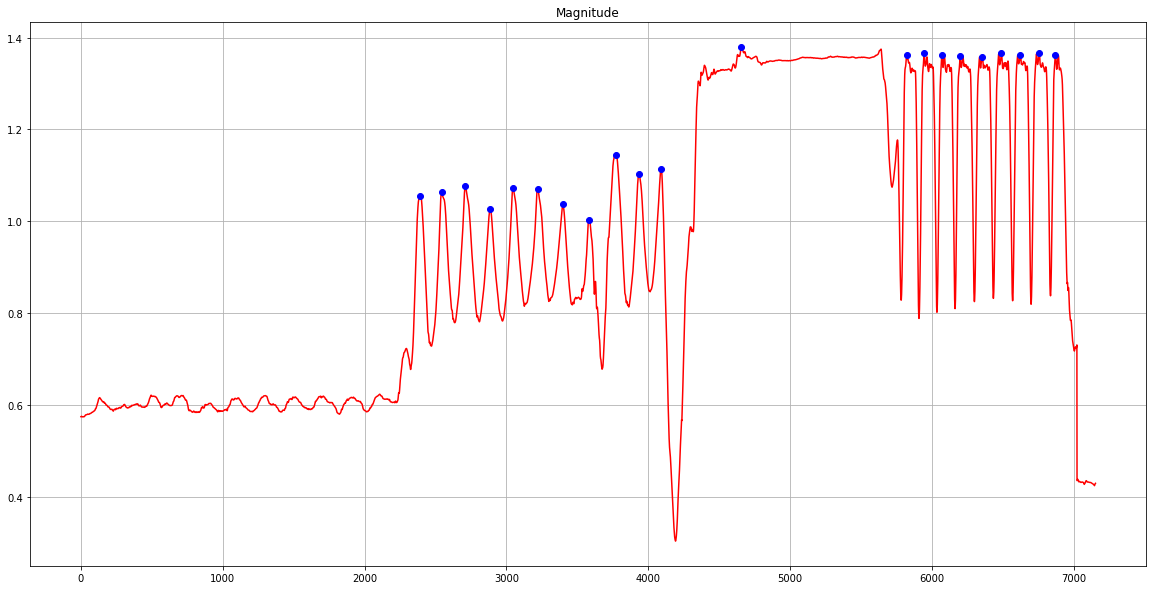

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from scipy.signal import butter, freqz, filtfilt, firwin, iirnotch, lfilter
from data_extract_iphone import pull_data, pull_orientation_data
import os
import sys
import csv
import numpy as np
from sklearn import model_selection, metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from features import extract_features
from util import slidingWindow, reorient, reset_vars
import pickle
import scipy
from scipy.signal import find_peaks
from matplotlib import collections  as mc

accel_file = 'data'
data = np.genfromtxt("demo.csv", delimiter=',',skip_header=1)
qx, qy, qz, qw, yaw, roll, pitch, timestamps = pull_orientation_data(accel_file, 'demo')
plt.figure(figsize=(20,10))
pl.plot(range(0,len(qx)), qx, 'r-',label='x data')
pl.plot(range(0,len(qx)), qy, 'g-',label='y data')
pl.plot(range(0,len(qx)), qz, 'b-',label='z data')
pl.plot(range(0,len(qx)), qw, 'o-',label='w data')
plt.title("test data")
plt.legend(loc = "upper left")
plt.grid()
plt.show()

plt.figure(figsize=(20,10))
magnitude = []
for i in range(len(qx)):
    magnitude.append((qx[i]**2+qy[i]**2+qx[i]**2+qz[i]**2)**(1/2))
peaks = find_peaks(magnitude,prominence=0.15) #set prominence to eliminate small oscillating peaks 
print(peaks[0])
print(len(magnitude))
coordinatesX, coordinatesY = [],[]
coordinatesX = peaks[0]
j = 0
for i in range(0,len(magnitude)):
    if j >= len(peaks[0]):
        break
    if i == peaks[0][j]:
        coordinatesY.append(magnitude[peaks[0][j]])
        j += 1
plt.figure(figsize=(20,10))
pl.plot(range(0,len(qx)), magnitude, 'r-')
pl.plot(coordinatesX, coordinatesY, 'bo',label='step counted')
plt.title("Magnitude")
plt.grid()
plt.show()

In [10]:
loaded_model = pickle.load(open("classifier.pickle", 'rb'))
print("Reorienting accelerometer data...")
sys.stdout.flush()
reset_vars()

#reoriented = np.asarray([reorient(data[i,4], data[i,3], data[i,2]) for i in range(len(data))])
#print(reoriented[0])
#reoriented_data_with_timestamps = np.append(data[:,0:1],reoriented,axis=1)
#print(reoriented_data_with_timestamps[0])
#data = np.append(reoriented_data_with_timestamps, data[:,-1:], axis=1)


#print(data[0])
# %%---------------------------------------------------------------------------
#
#		                Extract Features & Labels
#
# -----------------------------------------------------------------------------

window_size = 20
step_size = 20


print("Extracting features and labels for window size {} and step size {}...".format(window_size, step_size))
sys.stdout.flush()

X = []
Y = []

for i,window_with_timestamp_and_label in slidingWindow(data, window_size, step_size):
    window = window_with_timestamp_and_label[:,2:] 
    feature_names, x = extract_features(window)
    X.append(x)
predictions = loaded_model.predict(X)

predictions = np.repeat(predictions,21, axis=0)
reader = csv.reader(open('demo.csv', 'r'))
writer = csv.writer(open('output.csv', 'w'))
#headers = next(reader)
#headers.append("predicted class")
#writer.writerow(headers)
i=0
for row in reader:
    row.append(predictions[i])
    i+=1
    writer.writerow(row)


Reorienting accelerometer data...
Extracting features and labels for window size 20 and step size 20...
/Users/yassmenmekky/cs328/final-tyk/features.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return [max(np.fft.rfft(magnitude).astype(float))]
/Users/yassmenmekky/cs328/final-tyk/features.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  return [max(np.fft.rfft(magnitude).astype(float))]


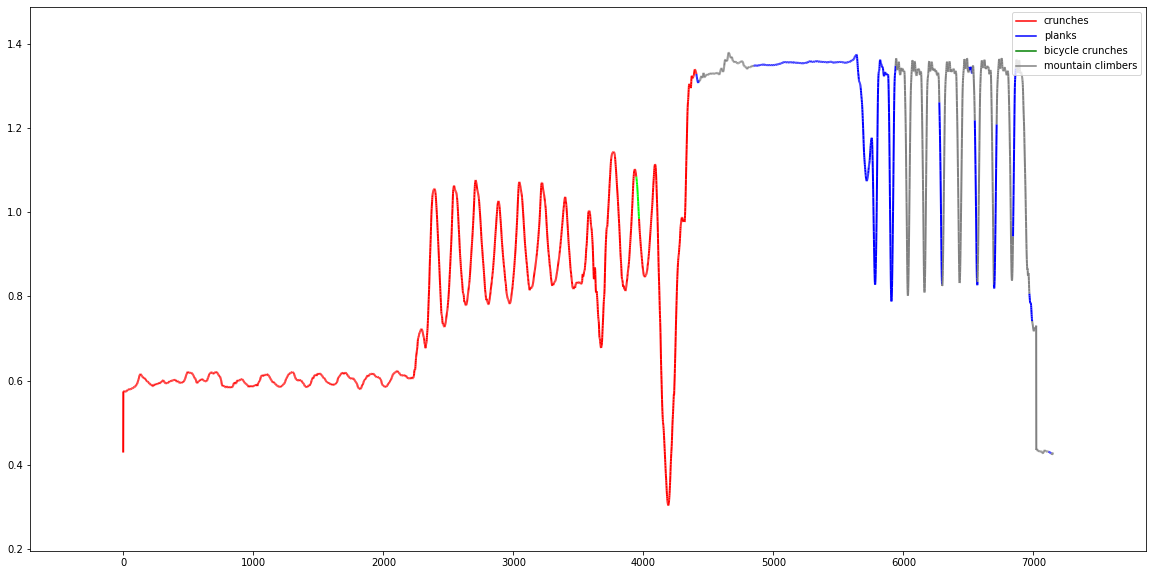

In [12]:
color = []
f = open('output.csv')
f.readline()
for line in f:
    value = line.split(',')
    color.append(float(value[-1]))


sittingX, sittingY = [], []
walkingX, walkingY = [], []
standingX, standingY = [], []
runningX, runningY = [], []
lines = []
colors = []

for i in range(len(color)):
    if i >= len(color):
        print(i)
    if(color[i] == 1):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([1,0,0])
        sittingX.append(i)
        sittingY.append(magnitude[i])
    if(color[i]==2):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0,0,1])
        walkingX.append(i)
        walkingY.append(magnitude[i])
    if(color[i]==3):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0,1,0])
        standingX.append(i)
        standingY.append(magnitude[i])
    if(color[i]==4):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0.5,0.5,0.5])
        runningX.append(i)
        runningY.append(magnitude[i])
lc = mc.LineCollection(lines, colors=colors, linewidths=2)
fig, ax = pl.subplots(figsize=(20,10))
ax.plot([],[], color='r', label='crunches')
ax.plot([],[], color='b', label='planks')
ax.plot([],[], color='g', label='bicycle crunches')
ax.plot([],[], color='gray', label='mountain climbers')
ax.legend(loc="upper right")
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
#red - sitting blue - standing green - walking gray - running